In [197]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np

from tqdm import tqdm
from scipy.stats import gaussian_kde
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from transformers import BertTokenizer, BertModel

from IPython.display import Markdown, HTML

### Read Comments/Reviews

In [2]:
directory = "../dat/甜點"
all_comments = []

# 遍歷目錄中的所有文件
file_names = os.listdir(directory)
for file_name in file_names:
    file_path = os.path.join(directory, file_name)
    if not os.path.isfile(file_path): continue
    if not file_path.endswith('.json'): continue
    if os.path.getsize(file_path) == 0: continue
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            comments = data.get('comments', [])
            all_comments.extend(comments)
    except: 
        print("something wrong in "+file_path)

print(len(all_comments))

26087


### Read Emoji

In [3]:
file_path = "../emoji/emoji-zh.json"
emojis = {}
with open(file_path, "r", encoding="utf-8") as f:
    emojis = json.load(f)
print(emojis['😀'])

笑臉


In [4]:
def replace_emojis(text, emoji_dict):
    for emoji, desc in emoji_dict.items():
        text = text.replace(emoji, f"[{desc}]")
    return text

replace_emojis("這是一個包含表情符號的句子😍，我們需要處理它😂。", emojis)

'這是一個包含表情符號的句子[花痴]，我們需要處理它[感動]。'

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertModel.from_pretrained('bert-base-chinese')

In [6]:
def get_bert_embedding(text):
    text = replace_emojis(text, emojis)
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    return torch.mean(last_hidden_states, 1).squeeze().detach().numpy()

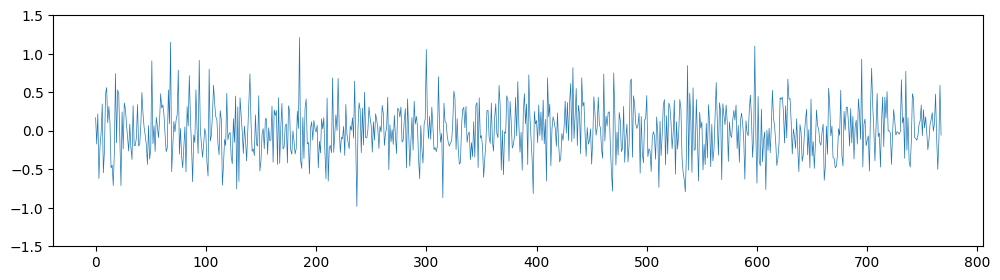

In [23]:
plt.figure(figsize=(12,3))
t1 = get_bert_embedding("[流口水]")
t2 = get_bert_embedding("流口水")
plt.plot(t1-t2, linewidth=0.5)
plt.ylim(-1.5, 1.5)
plt.show()

In [27]:
df = pd.DataFrame(all_comments)
df = df.drop(columns='other').dropna(subset=['comment'])
df

author                                            comment  \
0      TZU-HSUAN CHUANG  這間 有錢也買不到\n營不營業 在不在這裡擺\n全部看老闆心情啊啊啊啊啊！\n妳無論怎麼問 ...   
1         chelsea chang  1.照片右邊的是此家店的，左邊是在東市場裡買的。2.價格都是$20。3.可看出，右邊的較透明...   
2             sho micky                       綠豆露雖然有點甜但好吃\n還有菜燕 現在很難吃到傳統點心   
3                Arlene  好吃，而且不會很甜，就是小時候記憶中的味道！早起的鳥兒有蟲吃，賣完就收攤了，太晚去會撲空喔！...   
4            Yuehua Wun                              古早味零負擔小點心，冰冰涼涼又清甜，銅板價   
...                 ...                                                ...   
26079               林明宏                                      東西好吃😋 最愛花生什麼思   
26080      Yu Zheng Lin                                            雞蛋糕蕭喝假！   
26081               郭穎錡                                             超好吃😋推推   
26084               楊映彤  老闆人超好🥹本來是路過要買豆花，結果想吃的芋圓跟粉粿都沒有了🤣臨走前就被老闆塞了三個車輪餅說...   
26085             Katya       點了可以挑5樣料的綜合冰 50塊\n每樣料都很天然 很喜歡\n可以感覺得出老闆的用心！推   

       star  
0         5  
1         3  
2         5  
3         5  
4         5  
...     ...  
26079     5  
26080     5  
26081     5  
26084     5  
26085     5  

[21627 rows x 3 columns]

In [35]:
# 初始化空列表來存儲嵌入
embeddings = []

# 使用tqdm顯示進度條
for comment in tqdm(df['comment'], desc="Calculating BERT embeddings"):
    # 對評論進行分詞，先進行類型檢查和處理
    embedding = get_bert_embedding(comment)
    embeddings.append(embedding)

# 將嵌入添加到數據框
df['bert_embedding'] = embeddings

Calculating BERT embeddings: 100%|████████| 21627/21627 [14:46<00:00, 24.39it/s]


In [36]:
X = np.vstack(df['bert_embedding'].values)

Using ***Principal Component Analysis (PCA)*** method

In [102]:
reduced_X = PCA(n_components=2).fit_transform(X)
df['PCA'] = reduced_X.tolist()

In [103]:
kde = gaussian_kde(reduced_X.T)
density = kde(reduced_X.T)

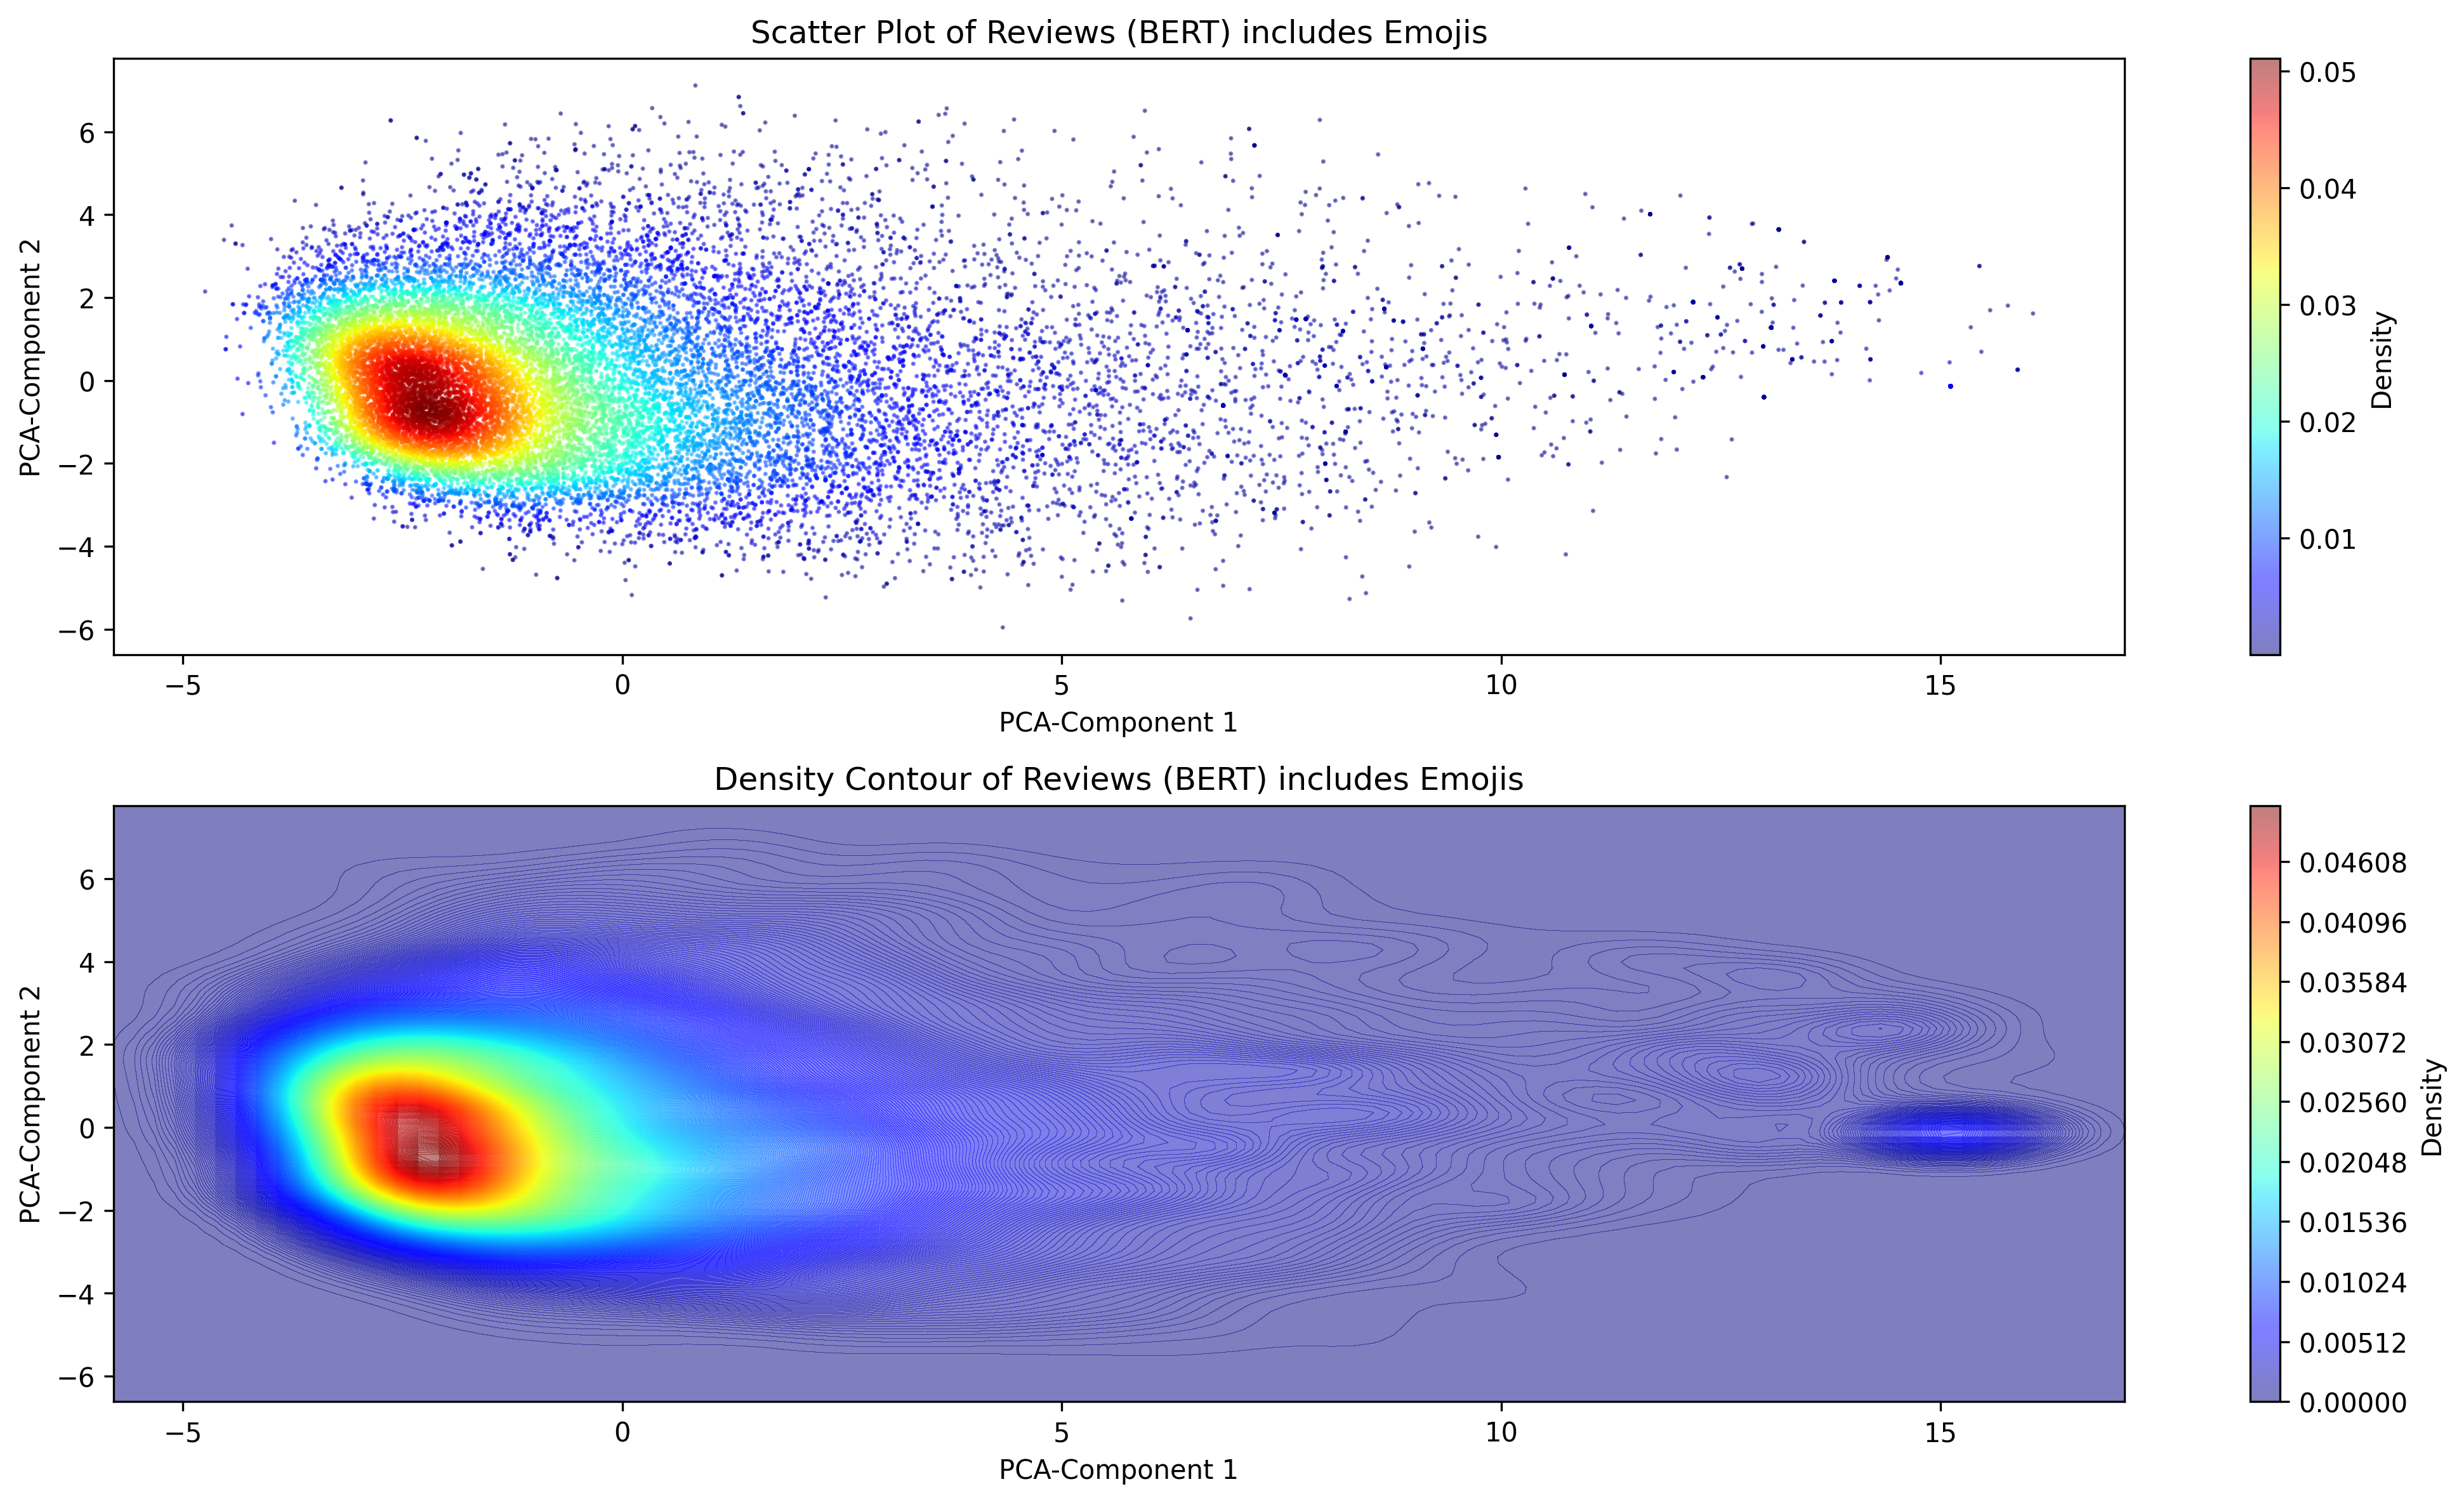

In [104]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), dpi=300)

sc = ax1.scatter(reduced_X[:, 0], reduced_X[:, 1], c=density, cmap='jet', s=0.5, alpha=0.5)
ax1.set_title('Scatter Plot of Reviews (BERT) includes Emojis')
ax1.set_xlabel('PCA-Component 1')
ax1.set_ylabel('PCA-Component 2')
plt.colorbar(sc, ax=ax1, label='Density')

(xmin, xmax), (ymin, ymax) = ax1.get_xlim(), ax1.get_ylim()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
f = np.reshape(kde(positions).T, xx.shape)

contour = ax2.contourf(xx, yy, f, cmap='jet', alpha=0.5, levels=800)
ax2.set_title('Density Contour of Reviews (BERT) includes Emojis')
ax2.set_xlabel('PCA-Component 1')
ax2.set_ylabel('PCA-Component 2')
plt.colorbar(contour, ax=ax2, label='Density')
plt.tight_layout()
plt.show()

Using ***Elbow Method*** by observing the relation between **Sum of Squared Errors** and **Cluster number**

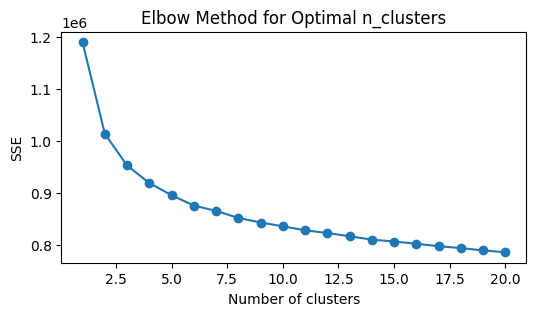

In [42]:
# 使用肘部法則確定最佳的聚類數量
sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# 繪製肘部法則圖
fig = plt.figure(figsize=(6, 3))
plt.plot(range(1, 21), sse, marker='o')
plt.title('Elbow Method for Optimal n_clusters')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

### Using K-Means to classify the comment

In [77]:
# TAKING A LOT OF TIME
for n_cluster in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    kmeans = KMeans(n_clusters=n_cluster, random_state=23)
    sil_score = silhouette_score(X, kmeans.fit_predict(X))
    print(f"cluster: {n_cluster}\t Silhouette Score: {sil_score}")

cluster: 2	 Silhouette Score: 0.3072526454925537
cluster: 3	 Silhouette Score: 0.15998475253582
cluster: 4	 Silhouette Score: 0.09114320576190948
cluster: 5	 Silhouette Score: 0.08044373244047165
cluster: 6	 Silhouette Score: 0.06446624547243118
cluster: 7	 Silhouette Score: 0.04027854651212692
cluster: 8	 Silhouette Score: 0.03933613374829292
cluster: 9	 Silhouette Score: 0.024797091260552406
cluster: 10	 Silhouette Score: 0.019808169454336166


In [145]:
# 使用 K-means 進行聚類
kmeans2 = KMeans(n_clusters=2, random_state=23)
df['cluster2'] = kmeans2.fit_predict(X)

kmeans3 = KMeans(n_clusters=3, random_state=23)
df['cluster3'] = kmeans3.fit_predict(X)

kmeans4 = KMeans(n_clusters=4, random_state=23)
df['cluster4'] = kmeans4.fit_predict(X)

kmeans5 = KMeans(n_clusters=5, random_state=23)
df['cluster5'] = kmeans5.fit_predict(X)

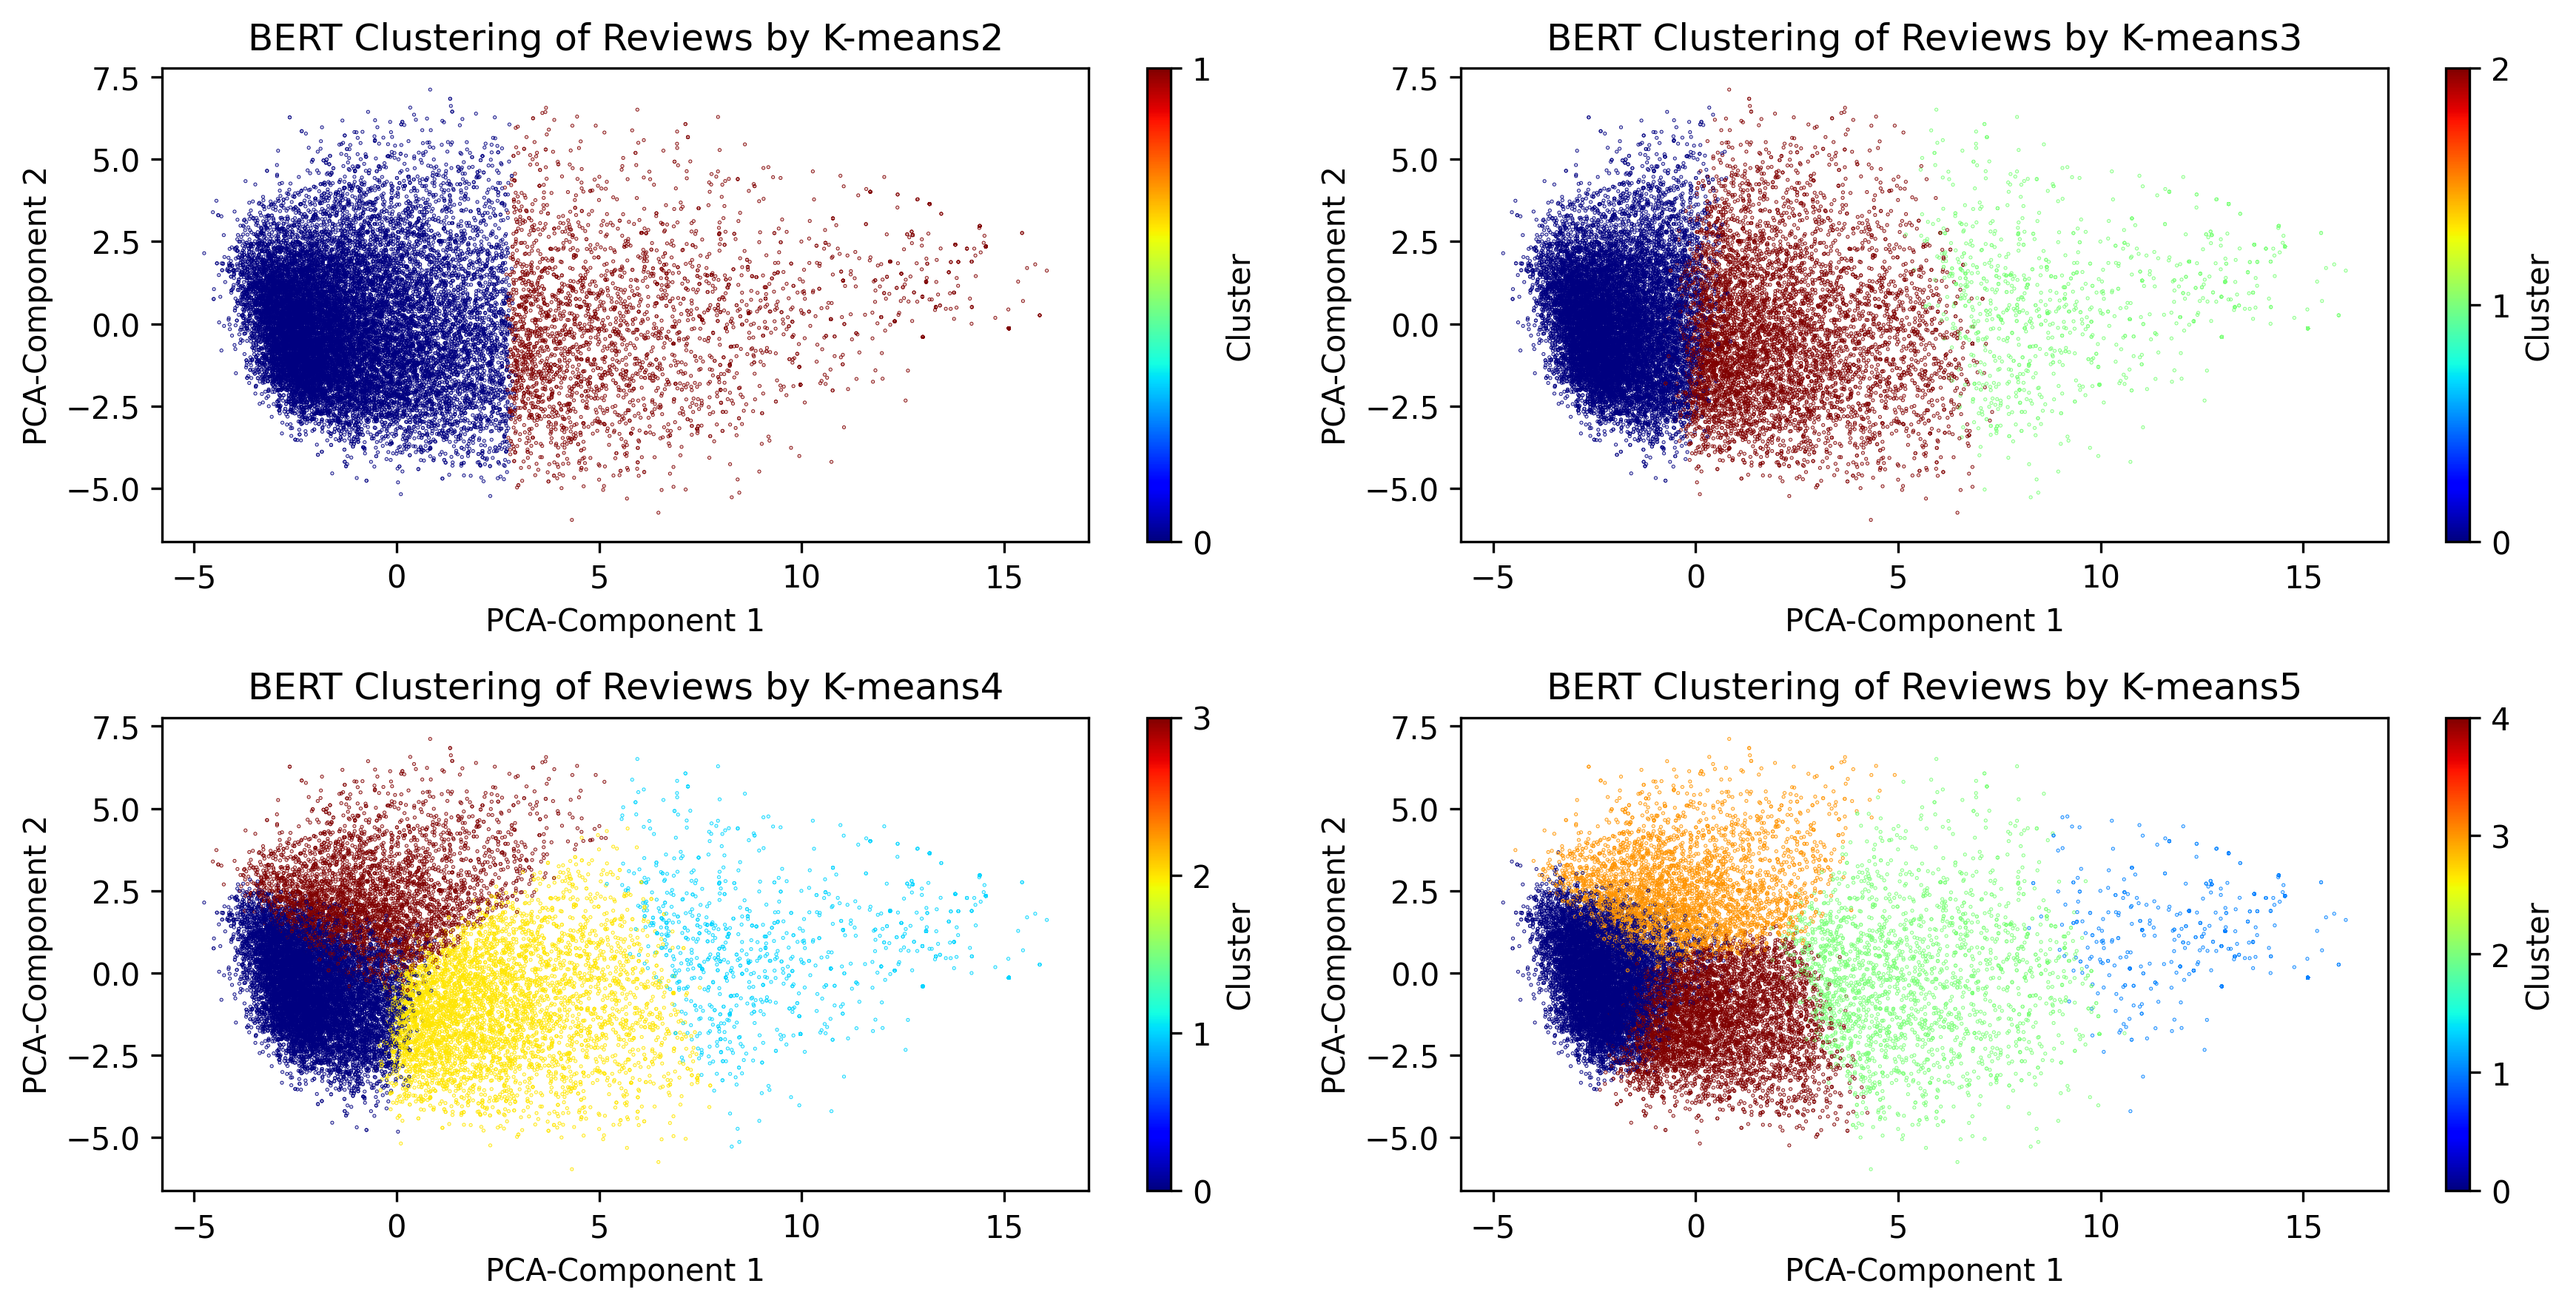

In [153]:
# 繪製結果
n_clusters = [2, 3, 4, 5]
fig, axs = plt.subplots(2, 2, figsize=(12, 6), dpi=300)
for n_cluster, ax in zip(n_clusters, axs.flatten()):
    sc = ax.scatter(reduced_X[:, 0], reduced_X[:, 1], c=df[f'cluster{n_cluster}'], cmap='jet', s=0.05)
    ax.set_title(f'BERT Clustering of Reviews by K-means{n_cluster}')
    ax.set_xlabel('PCA-Component 1')
    ax.set_ylabel('PCA-Component 2')
    plt.colorbar(sc, ax=ax, label='Cluster', ticks=np.arange(df[f'cluster{n_cluster}'].min(), df[f'cluster{n_cluster}'].max() + 1))

plt.tight_layout()
plt.show()

In [163]:
contamination_values = [0.01, 0.05, 0.1, 0.15, 0.2]
for contamination in contamination_values:
    isolation_forest = IsolationForest(contamination=contamination, random_state=42)
    df[f'anomaly-{contamination}'] = isolation_forest.fit_predict(X)

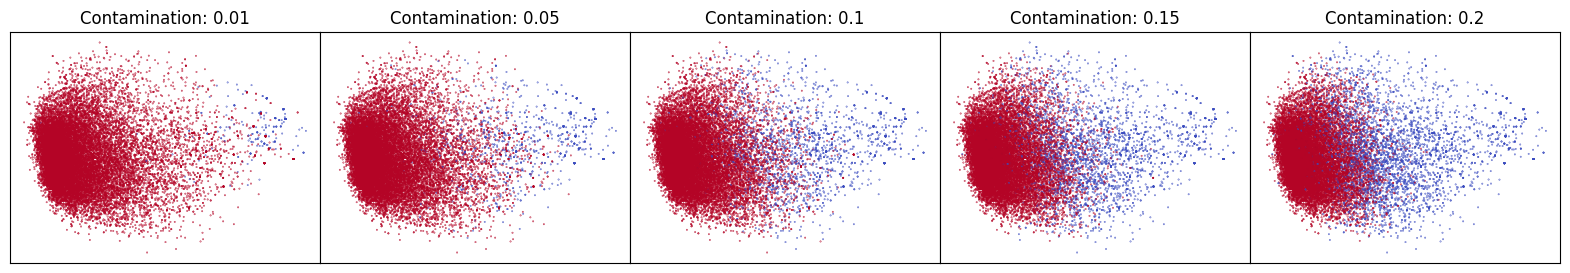

In [165]:
# 可視化不同 contamination 值下的結果
fig, axes = plt.subplots(1, len(contamination_values), figsize=(20, 3), sharex=True, sharey=True)
for i, contamination in enumerate(contamination_values):
    axes[i].scatter(reduced_X[:, 0], reduced_X[:, 1], c=df[f'anomaly-{contamination}'], cmap='coolwarm', s=0.1)
    axes[i].set_title(f'Contamination: {contamination}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.subplots_adjust(wspace=0)
plt.show()

In [233]:
for contamination_value in contamination_values:
    anomalies = df[df[f'anomaly-{contamination_value}'] == -1]
    anomaly_counts = anomalies['comment'].value_counts()
    
    grouped_comments = {}
    for comment, count in anomaly_counts.items():
        if count not in grouped_comments: grouped_comments[count] = []
        grouped_comments[count].append(comment)

    display(Markdown(f"### Contamination values: {contamination_value}"))
    comment_count = "<div style='display: flex; flex-wrap: wrap; overflow-y: auto; max-height: 100px;'>"
    
    for count, comments in sorted(grouped_comments.items())[::-1]:
        if(count==1): continue
        for comment in comments:
            comment_count += f"""
            <span style='border: 1px solid #ccc; border-radius: 5px; margin: 1px; display: inline-block; padding: 1px 5px;'>
                <span>{comment}</span> x{count}
            </span>
            """
    comment_count += "...</div>"
    display(HTML(comment_count))

### Contamination values: 0.01

### Contamination values: 0.05

### Contamination values: 0.1

### Contamination values: 0.15

### Contamination values: 0.2

In [235]:
# 將DataFrame存儲為JSON文件
df.to_json('dat/clustered_reviews-emojis.json', orient='records', force_ascii=False)

In [240]:
df.drop(columns="bert_embedding").to_json('visual/pca_clustered_reviews-emojis.json', orient='records', force_ascii=False)